In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

from random import randint

import tensorflow.keras as tfk
import tensorflow_hub as hub
import tensorflow.keras.layers as tfkl
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix


2025-06-03 12:06:07.622211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748952367.849683      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748952367.920149      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dataset = tf.keras.utils.image_dataset_from_directory("/kaggle/input/tf-classification-data/seg_train/seg_train", image_size=(150, 150), seed=69, color_mode="rgb")
test_dataset = tf.keras.utils.image_dataset_from_directory("/kaggle/input/tf-classification-data/seg_test/seg_test", image_size=(150, 150), seed=69, color_mode="rgb")

len(train_dataset)

Found 14034 files belonging to 6 classes.


I0000 00:00:1748947129.275202      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 3000 files belonging to 6 classes.


439

Let's visualise the class distribution in the training dataset...

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Class distribution in training dataset:
buildings: 2191 images
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


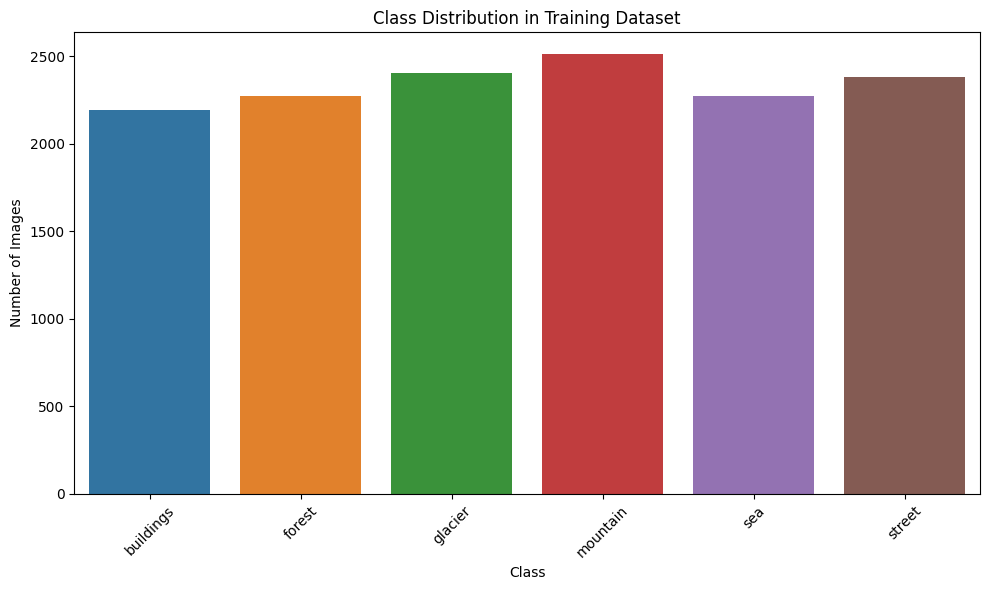

In [3]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
print(f"Classes: {class_names}")

class_counts = {name: 0 for name in class_names}

for images, labels in train_dataset:
    label_counts = Counter(labels.numpy())
    
    for label, count in label_counts.items():
        class_counts[class_names[label]] += count

print("\nClass distribution in training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We have a nicely distributed training dataset...

Visualing an image in the dataset...

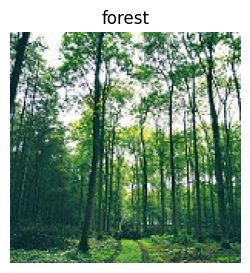

In [4]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(3, 3))
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f"{class_names[labels[0]]}")
    plt.axis("off")
    plt.show()


---

Before anything else, we need to preprocess the images in the datasets. This may include normalising / rescaling pixel values, converting to greyscale, and maybe tweaking contrast...

In [5]:
# rescale data
train_dataset = train_dataset.map(lambda x, y : (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y : (x / 255.0, y))

for image, labels in train_dataset.take(1):
    print((np.min(image[0]), np.max(image[0])))
    print(image[0].shape)
    
# improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


(0.0, 1.0)
(150, 150, 3)


Let's make a model!

In [6]:
model = tfk.Sequential([tfkl.Conv2D(32, kernel_size=3, strides=1, kernel_regularizer=l2(0.0001) ,input_shape=(150, 150, 3)), tfkl.BatchNormalization(), tfkl.ReLU(), tfkl.MaxPool2D(),
                        tfkl.Conv2D(128, kernel_size=3, strides=1, kernel_regularizer=l2(0.0001)), tfkl.BatchNormalization(), tfkl.ReLU(), tfkl.MaxPool2D(),
                        tfkl.Conv2D(256, kernel_size=3, strides=1), tfkl.BatchNormalization(), tfkl.ReLU(), tfkl.MaxPool2D(),
                        
                        tfkl.Flatten(), tfkl.Dense(128), tfkl.BatchNormalization(), tfkl.ReLU(), tfkl.Dropout(0.5),
                        tfkl.Dense(256), tfkl.BatchNormalization(), tfkl.ReLU(),
                        tfkl.Dense(len(class_names))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
for batch, _ in train_dataset:
    print(batch.shape)
    break

model.compile(optimizer="adam", loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

(32, 150, 150, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 72, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       9,470,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 9,840,902 (37.54 MB)

 Trainable params: 9,839,302 (37.53 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [8]:
# # dynamic LR
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',       
    factor=0.5,               
    patience=3,                
    verbose=1,                 
    min_lr=1e-6
)

n_epochs = 30

history = model.fit(train_dataset, validation_data=test_dataset, epochs=n_epochs, callbacks=[lr_scheduler])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/30


I0000 00:00:1748947159.529935     100 service.cc:148] XLA service 0x7ae3480036d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748947159.530770     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748947160.037283     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.2928 - loss: 1.8819   

I0000 00:00:1748947165.110526     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.5962 - loss: 1.0522 - val_accuracy: 0.5207 - val_loss: 1.4168 - learning_rate: 0.0010
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7745 - loss: 0.6314 - val_accuracy: 0.4857 - val_loss: 1.5275 - learning_rate: 0.0010
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8054 - loss: 0.5272 - val_accuracy: 0.7797 - val_loss: 0.6001 - learning_rate: 0.0010
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8244 - loss: 0.4877 - val_accuracy: 0.7247 - val_loss: 0.7479 - learning_rate: 0.0010
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8563 - loss: 0.4069 - val_accuracy: 0.8133 - val_loss: 0.5181 - learning_rate: 0.0010
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8801 - loss: 0.3530 - val_accuracy: 0.7770 - val_loss: 0.6657 - learning_rate: 0.0010
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8913 - loss: 0.3111

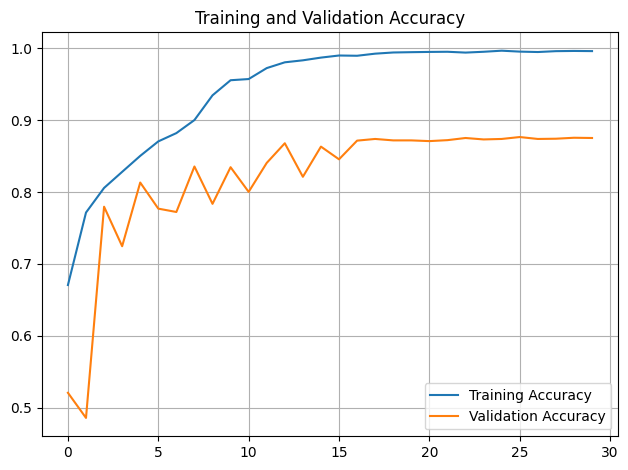

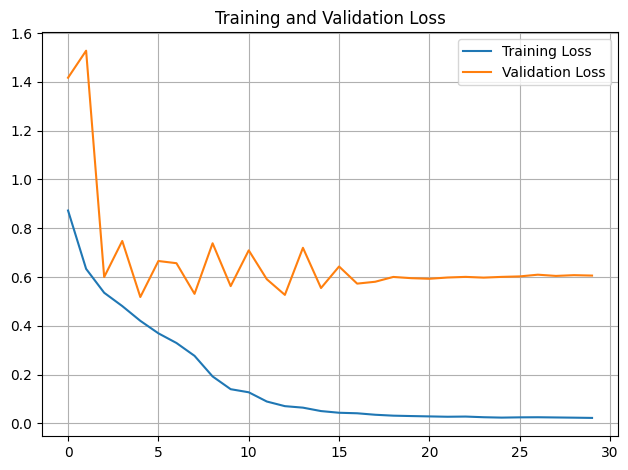

In [9]:
epochs_range = range(n_epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

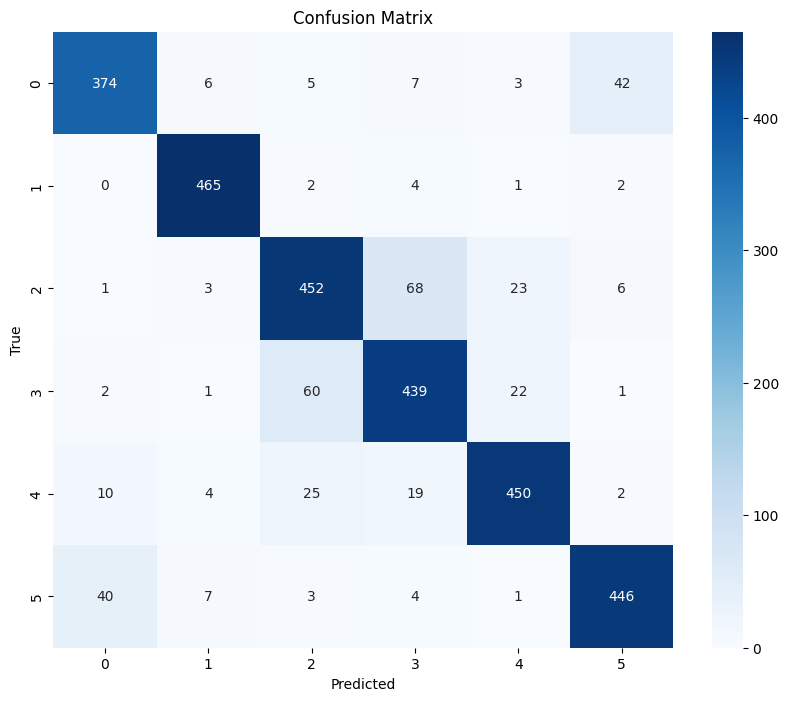

In [10]:
y_true = []
y_pred_classes = []

# Loop through the dataset
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())  # assuming one-hot encoded labels
    y_pred_classes.extend(np.argmax(preds, axis=1))
    

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
model.save('image_classifier.keras')

---

In [12]:
saved_model = tfk.models.load_model('image_classifier.keras')

Let's try to predict some images from the pred dataset...

In [13]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

pred_dataset = tf.keras.utils.image_dataset_from_directory("/kaggle/input/tf-classification-data/seg_pred/", image_size=(150, 150), seed=69, color_mode="rgb")
pred_dataset = pred_dataset.map(lambda x, y: (x / 255.0, y))

Found 7301 files belonging to 1 classes.


Selecting Batch # 122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


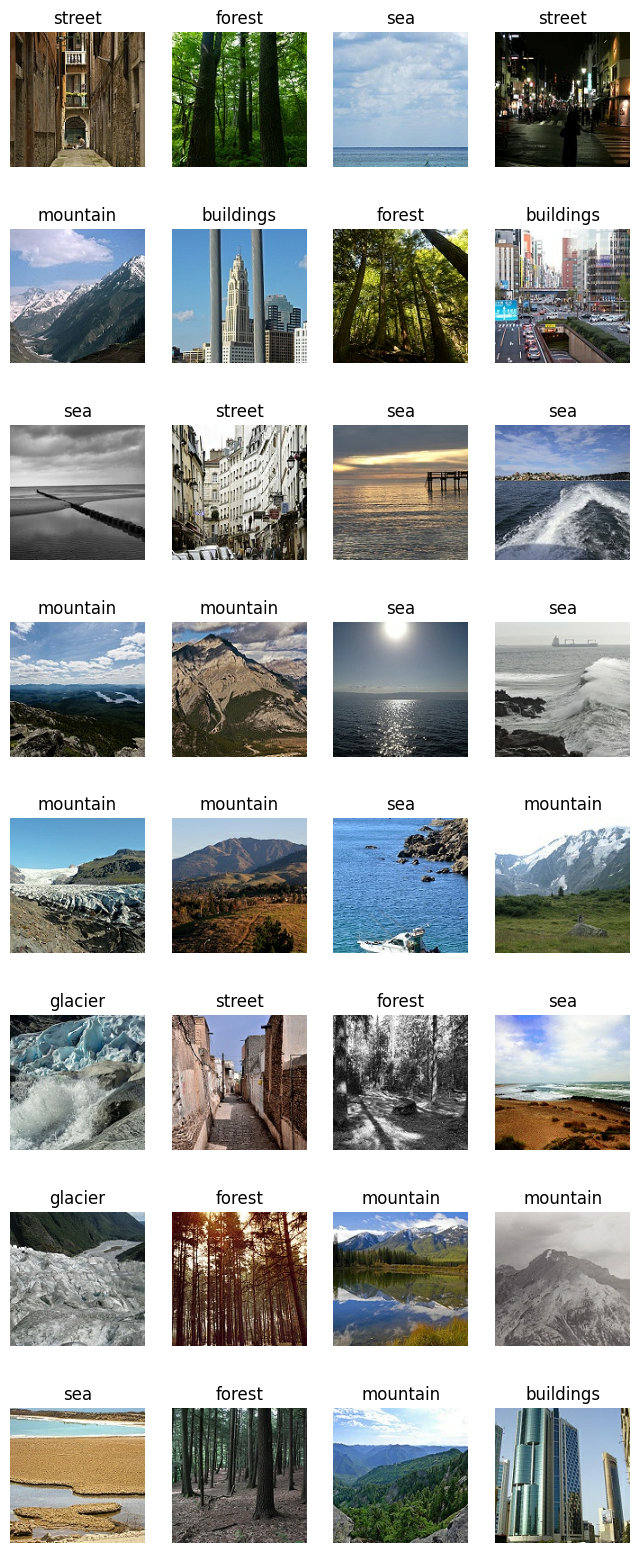

In [14]:
fig, axes = plt.subplots(8, 4, figsize=(8, 20))
axes = axes.flatten()

random_idx = randint(1, 229)
print(f"Selecting Batch # {random_idx}")


for imgs, labels in pred_dataset.skip(random_idx - 1).take(1):
    # print(imgs.shape)
    
    # get predictions for the images
    preds = saved_model.predict(imgs)
    pred_classes = tf.argmax(preds, axis=1)

    for i in range(len(imgs)):
        axes[i].set_axis_off()
        axes[i].imshow(imgs[i].numpy())
        axes[i].set_title(f"{class_names[pred_classes[i]]}")

Pretty happy with the predictions the model gives me. It definitely gets caught when the images combine two or more classifications as once, such as streets and buildings, or mountains with glaciers and/or forests, but that's to be expected.

---

### Transfer Learning

Let's now use a pre-built feature vector/generator with a custom classifier head...

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory("/kaggle/input/tf-classification-data/seg_train/seg_train", image_size=(150, 150), seed=69, color_mode="rgb")
test_dataset = tf.keras.utils.image_dataset_from_directory("/kaggle/input/tf-classification-data/seg_test/seg_test", image_size=(150, 150), seed=69, color_mode="rgb")
pred_dataset = tf.keras.utils.image_dataset_from_directory("/kaggle/input/tf-classification-data/seg_pred/", image_size=(150, 150), seed=69, color_mode="rgb")

Found 14034 files belonging to 6 classes.


I0000 00:00:1748952388.021500      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


In [9]:
inception_v3_url = "https://www.kaggle.com/models/google/inception-v3/TensorFlow2/feature-vector/2"

inputs = tf.keras.Input(shape=(299, 299, 3))

feature_extractor_layer = hub.KerasLayer(
    inception_v3_url,
    trainable=True
)

x = feature_extractor_layer(inputs)

outputs = tf.keras.layers.Dense(6)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_3 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 21815078 (83.22 MB)
Trainable params: 21780646 (83.09 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [16]:
# need to rescale images for this model
# inevitobly, I need to retrain the entire model to work on different dimensions
def preprocess_image(image, target_size=(299, 299)):
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0 
    return image

train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_image(x), y))
pred_dataset = pred_dataset.map(lambda x, y: (preprocess_image(x), y))

In [13]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',       
    factor=0.5,               
    patience=3,                
    verbose=1,                 
    min_lr=1e-6
)

n_epochs = 15

history = model.fit(train_dataset, validation_data=test_dataset, epochs=n_epochs, callbacks=[lr_scheduler])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/15
439/439 [==============================] - 126s 286ms/step - loss: 0.6209 - accuracy: 0.8703 - val_loss: 0.8240 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 2/15
439/439 [==============================] - 120s 274ms/step - loss: 0.5525 - accuracy: 0.8892 - val_loss: 0.7363 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 3/15
439/439 [==============================] - 120s 274ms/step - loss: 0.4933 - accuracy: 0.9052 - val_loss: 0.8309 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 4/15
439/439 [==============================] - 120s 274ms/step - loss: 0.4784 - accuracy: 0.9052 - val_loss: 1.0184 - val_accuracy: 0.7290 - lr: 0.0010
Epoch 5/15
439/439 [==============================] - 120s 274ms/step - loss: 0.4408 - accuracy: 0.9185 - val_loss: 0.6943 - val_accuracy: 0.8223 - lr: 0.0010
Epoch 6/15
439/439 [==============================] - 120s 274ms/step - loss: 0.4265 - accuracy: 0.9228 - val_loss: 1.1900 - val_accuracy: 0.6947 - lr: 0.0010
Epoch 7/15
439/439 [==========================

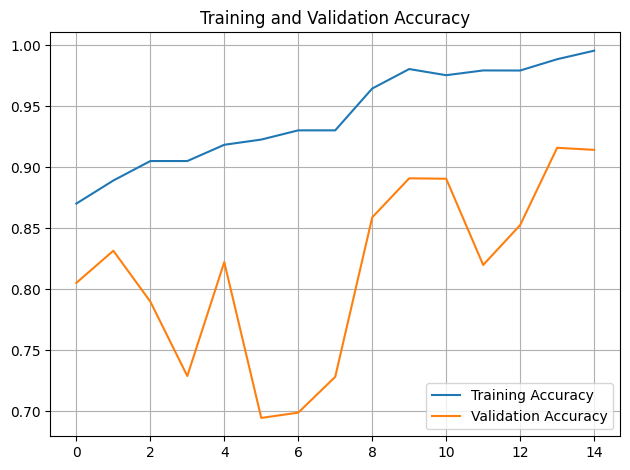

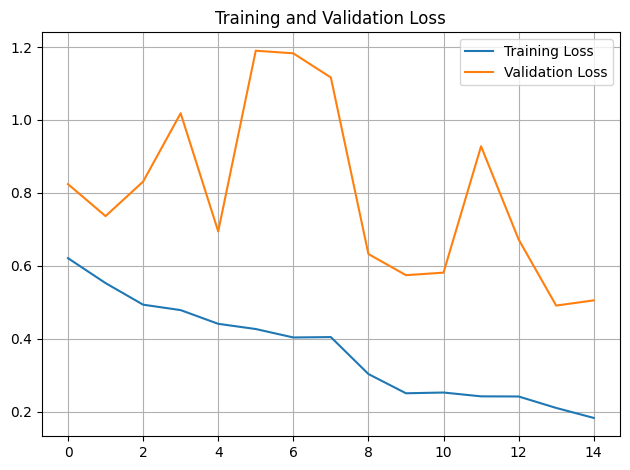

In [15]:
epochs_range = range(n_epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()
plt.tight_layout()
plt.show()

Selecting Batch # 115
1/1 [==============================] - 0s 42ms/step


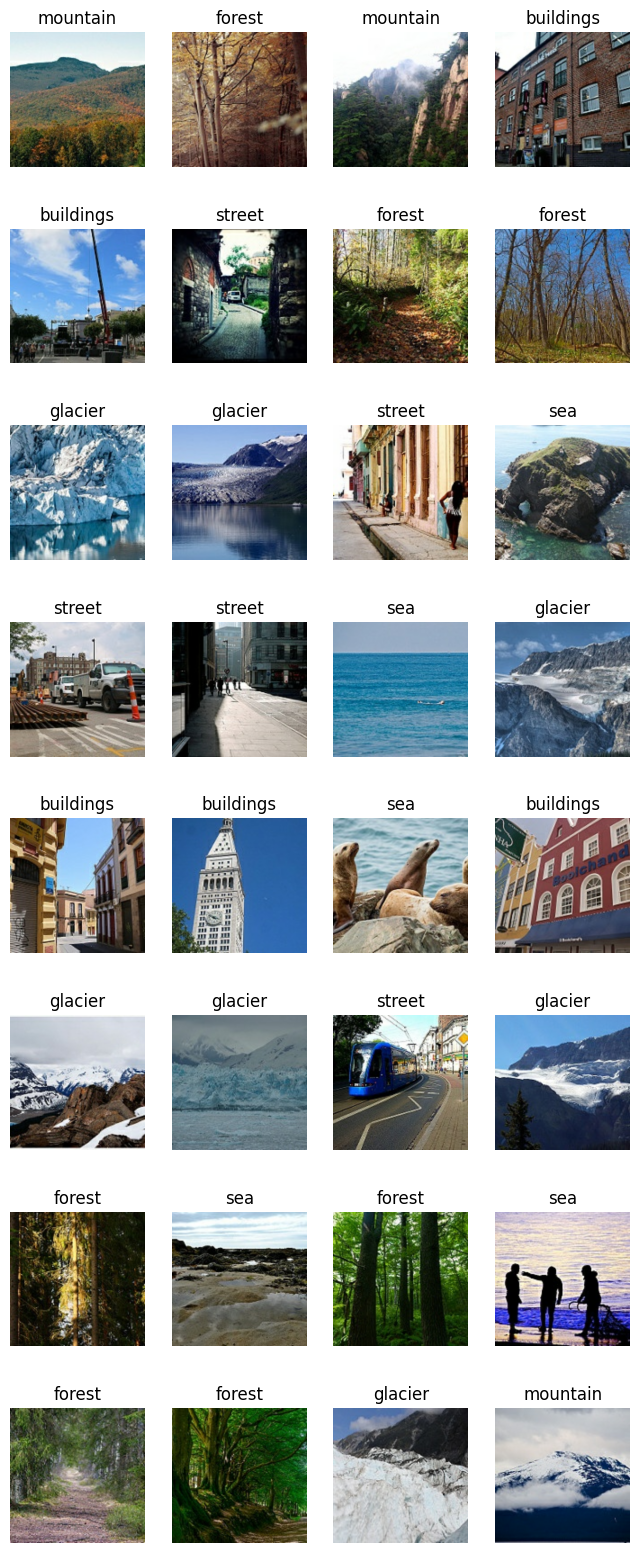

In [19]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

fig, axes = plt.subplots(8, 4, figsize=(8, 20))
axes = axes.flatten()

random_idx = randint(1, 229)
print(f"Selecting Batch # {random_idx}")


for imgs, labels in pred_dataset.skip(random_idx - 1).take(1):
    # print(imgs.shape)
    
    # get predictions for the images
    preds = model.predict(imgs)
    pred_classes = tf.argmax(preds, axis=1)

    for i in range(len(imgs)):
        axes[i].set_axis_off()
        axes[i].imshow(imgs[i].numpy())
        axes[i].set_title(f"{class_names[pred_classes[i]]}")